# Example Jupyter Notebook
In the following notebook, we will show how to build complex queries in GOR using the Python SDK to connect to our instance. First, as always, we load the gor magic extension to be able to use the `%gor` and `%%gor` syntax.
This notebook assumes you are familiar with the gor syntax.

In [1]:
# Install the python sdk and other python libraries here
! pip install nextcode-sdk[jupyter] -U > /dev/null
! pip install matplotlib -U > /dev/null

In [2]:
# import libraries and initialize magic extension
import pandas as pd
import matplotlib.pyplot as plt

%reload_ext nextcode
#%env LOG_QUERY=1 # set this to get information about queries

 Gor magic extension has been loaded. You can now use '%gor' and '%%gor' in this notebook
 * Python SDK Version: 0.3.22
 * Query API Version: 1.9.4
 * GOR Version: 9.5-SNAPSHOT (git SHA c4ca0fce323ab019ee24e5bee58ed3ccec8d4c2a)
 * Root Endpoint: https://platform.wuxinextcodedev.com/api/query/
 * Current User: jonb@wuxinextcode.com


#### Simple single-line gor expression

In [3]:
%gor nor #dbsnp# | top 2

,Chrom,pos,reference,allele,rsids
0,chr1,10020,AA,A,rs775809821
1,chr1,10039,A,C,rs978760828


#### Single-line gor expression which stores results in local variable

In [4]:
var = %gor nor #dbsnp# | top 2

#### Simple multi-line gor expression
Multi-line expressions are started with `%%`. Each statement should end with `;`

In [5]:
%%gor
  def #top# = 2;
  gor #dbsnp#
   | top #top#;

,Chrom,pos,reference,allele,rsids
0,chr1,10020,AA,A,rs775809821
1,chr1,10039,A,C,rs978760828


#### Multi-line gor expression which stores results in local variable
To load results from a multi-line gor expression into a variable you can use the special `<<` operator

In [6]:
%%gor new_results <<
def #tops# = 10;
gor #dbsnp# | top #tops#;

In [7]:
new_results.index

RangeIndex(start=0, stop=10, step=1)

#### Store results in the user_data folder
Instead of fetching the data to the jupyter server you can also use the << operator to store files in the user_data folder within the project on NFS.

In [8]:
%%gor user_data/outfile.gorz <<
  pgor #dbsnp#
   | top 1000;

In [9]:
# verify that the file is there by executing gorls
%gorls user_data outfile.gorz

outfile.gorz (345.1KiB)


In [10]:
# now you can gor this file and bring the results into a local dataframe
%gor user_data/outfile.gorz | GROUP chrom -count | top 2

,Chrom,bpStart,bpStop,allCount
0,chr1,0,248956422,2000
1,chr10,0,133797422,2000


#### Gor expression which references a local variable
Local variables can be references using the `$xxx` syntax. This will expand the variable inline and is meant to be used for simple strings and numbers

In [11]:
n = 5

In [12]:
%%gor
  gor -p chr1:69000-70000 #dbsnp#
   | TOP $n;

,Chrom,pos,reference,allele,rsids
0,chr1,69045,A,G,rs1360507296
1,chr1,69063,T,C,rs1260343719
2,chr1,69071,C,A,rs1314111151
3,chr1,69071,C,G,rs1314111151
4,chr1,69072,G,A,rs1379296286


#### Gor expression with defs and create statements

In [13]:
%%gor
def #number# = $n;
def #VEP_single# = UKBB/freezes/2019_0325/plink_wes/vep_single.gorz;
def #myfavouritefood# = pizza;

create mydbsnp = gor -p chr1:69000-70000 #dbsnp#
                  | TOP #number#;

gor [mydbsnp];

,Chrom,pos,reference,allele,rsids
0,chr1,69045,A,G,rs1360507296
1,chr1,69063,T,C,rs1260343719
2,chr1,69071,C,A,rs1314111151
3,chr1,69071,C,G,rs1314111151
4,chr1,69072,G,A,rs1379296286


#### Compound expressions
Using the local variables you can construct compount expressions, allowing you to split up long gor scripts.

In [14]:
defs = """
def #myfirstdef# = 2;
def #myseconddef# = 2;

"""
creates = """
create mydbsnp = gor -p chr1:69000-70000 #dbsnp#
                  | TOP #myfirstdef#;
"""

In [15]:
%%gor
 $defs
 $creates

 gor [mydbsnp];

,Chrom,pos,reference,allele,rsids
0,chr1,69045,A,G,rs1360507296
1,chr1,69063,T,C,rs1260343719


#### Virtual relations
You can load pandas dataframes into the query with the special `[var:xxx]` syntax.

In [16]:
allpns = pd.read_csv('data/allpns.tsv', delimiter='\t')

In [17]:
%%gor
  create bla = gor #dbsnp#
   | top 10;
  nor [var:allpns]
   | top 5;

,PN
0,1000786
1,1629813
2,5137728
3,1001070
4,2489370


#### Cancelling queries
Try executing this long-running query and then click the stop button

In [18]:
results = %gor gor #dbsnp# | GROUP chrom -count

Query has been cancelled


#### Graphing results
Since the primitive that is returned from magic gor commands is just a pandas dataframe we won't go into detail here on how to graph results since there is plenty of material available on the web.

Let's however give one brief example. Here we count the number of rows per chromosome from the *dbsnp* table and want to display it as a bar chart.

We start by running the query which is quite heavy since *dbnsp* is large but we only need to do this once. This query will run for 1-2 minutes, grab a cup of coffee.

In [19]:
%%gor df <<
pgor #dbsnp#
    | GROUP chrom -count
    | select 1,4

In [20]:
# add a new column that coverts chrom names to have leading 0 for lexical sorting. chr1 -> chr01, etc.
vals = []
for v in df.Chrom:
    vals.append(v if not v[-1].isdigit() else "chr{:02d}".format(int(v.split("chr")[1])))
df['sort_col'] = vals
df.sort_values("sort_col", inplace=True)

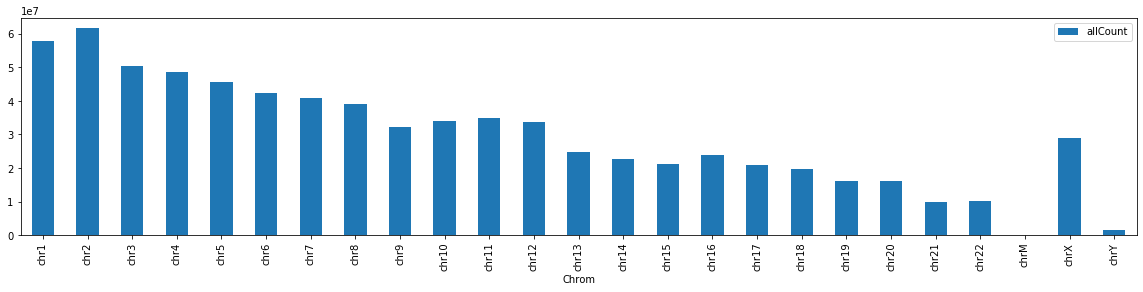

In [21]:
plt.rcParams["figure.figsize"] = (20,4)
df.plot(kind="bar", x="Chrom", y="allCount")
plt.show()

## Using the SDK without magic syntax
The `%` and `%%` is simply syntactic sugar for executing queries through the python sdk. You can use the sdk directly as well and that is probably the preferred method for serious analysis.

#### Initializing the SDK
The SDK usually needs to be initialized with an API key and a project. However, in Wuxi notebooks this has already been done for you.

In [22]:
#%env GOR_API_KEY=[jwt token]
#%env GOR_API_PROJECT=[project name]
import nextcode
import pandas as pd
# get a handle on a query service proxy
svc = nextcode.get_service("query")

#### Running basic queries

In [23]:
qry = svc.execute("gor #dbsnp# | top 2;")
print(f"Query {qry.query_id} is {qry.status}. Runtime was {qry.duration} ms and it produced {qry.line_count} rows.")
print(f"The query that was run: {qry.query}")
from pprint import pprint
df = qry.dataframe()
df

Query 2896 is DONE. Runtime was 39 ms and it produced 2 rows.
The query that was run: gor #dbsnp# | top 2;


,Chrom,pos,reference,allele,rsids
0,chr1,10020,AA,A,rs775809821
1,chr1,10039,A,C,rs978760828


#### Analysing failed queries

If you run a query through the SDK an exception will not be raised if the query fails. You will need to check for it explicitly. You can use the helper attribute 'failed' for control flow.

If a query failed then `status_message` will be set and shows a short error message. You can view more detailed information in the `query.error` dictionary.

In [27]:
qry = svc.execute("gor #unknowndef# | top 2;")
if qry.failed:
    import sys
    print(f"Query failed with error: {qry.status_message}\n", file=sys.stderr)
    print(f"Additional information available from qry.error[]: {list(qry.error.keys())}", file=sys.stderr)

Query failed with error: Resource not found for iterator: #unknowndef# #unknowndef#

Additional information available from qry.error[]: ['command', 'commandIndex', 'commandName', 'commandSource', 'description', 'errorType', 'gorMessage', 'message', 'requestId', 'stackTrace', 'type', 'uri']


#### Using virtual relations

In [28]:
import pandas as pd
import nextcode
svc = nextcode.get_service("query")

# use a dataframe as a virtual relation
df = pd.DataFrame(columns=["hello", "world"], data=[[1, 2]])
qry = svc.execute("gor [test]", test=df)
print(qry.dataframe())

# use a tsv string as a virtual relation
tsv = """hello\tworld\n1\t2"""
qry = svc.execute("gor [test]", test=tsv)
print(qry.dataframe())

# if your virtual relation uses special characters (:) in variable name
qry = svc.execute("gor [var:test]", relations=[{"name": "var:test", "data": df}])
print(qry.dataframe())

   hello  world
0      1      2
   hello  world
0      1      2
   hello  world
0      1      2


#### Using the Query Builder
The jupyter modules comes with a query builder which is a helper class for writing queries. Here is an example of how that might be used.

This is functionally equal to the *compound expressions* example above. 

In [29]:
from nextcode.services.query.jupyter import QueryBuilder
bld = QueryBuilder()
bld.creates["mydbsnp"] = "gor -p chr1:69000-70000 #dbsnp#"
bld.defs["#myfirstdef#"] = 2
bld.defs["#myseconddef#"] = 2
print(bld.render("gor [mydbsnp]"))

def #myfirstdef# = 2;
def #myseconddef# = 2;

create [mydbsnp] = gor -p chr1:69000-70000 #dbsnp#;

gor [mydbsnp]


In [30]:
qry = bld.execute("gor [mydbsnp]")

In [31]:
qry.dataframe()

,Chrom,pos,reference,allele,rsids
0,chr1,69045,A,G,rs1360507296
1,chr1,69063,T,C,rs1260343719
2,chr1,69071,C,A,rs1314111151
3,chr1,69071,C,G,rs1314111151
4,chr1,69072,G,A,rs1379296286
...,...,...,...,...,...
243,chr1,69968,A,G,rs1365205342
244,chr1,69986,C,A,rs1198102769
245,chr1,69989,A,C,rs1246160656
246,chr1,69989,A,G,rs1246160656
